In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import requests as rq

from tqdm.auto import tqdm

In [2]:
url = "https://gol.gg/tournament/tournament-matchlist/LEC%20Winter%20Season%202024/"
page = rq.get(url, headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"})
soup = BeautifulSoup(page.content, "html.parser")
links = soup.find("table").findAll("a", href = True)
match_links = [f"https://gol.gg{link['href'][2:-10]}" for link in links if not "preview" in link['href']]

In [3]:
match_infos =  []
game_stats = []

for game_id, link in tqdm(enumerate(match_links), total = len(match_links)):
    # Get the page
    url = f"{link}/page-game//"
    page = rq.get(url, headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"})
    soup = BeautifulSoup(page.content, "html.parser")

    # Get game time and convert to seconds
    game_time = soup.find("div", {"class" : "col-6 text-center"}).h1.text
    game_time = game_time.split(":")
    game_time = int(game_time[0]) * 60 + int(game_time[1])

    # Get blue team name and if they won
    blue_team_name = soup.find("div", {"class" : "col-12 blue-line-header"}).text.strip()
    blue_team_name, blue_side_win = blue_team_name.split(" - ")
    blue_side_win = int(blue_side_win == "WIN")

    # Get red team name
    red_team_name = soup.find("div", {"class" : "col-12 red-line-header"}).text.strip()
    red_team_name, red_side_win = red_team_name.split(" - ")

    # Get stats (kills, towers, dragons, barons, golds)
    blue_stats = [stat.text.strip() for stat in soup.findAll("span", {"class" : "score-box blue_line"})]
    red_stats = [stat.text.strip() for stat in soup.findAll("span", {"class" : "score-box red_line"})]

    blue_kills = int(blue_stats[0])
    blue_towers = int(blue_stats[1])
    blue_dragons = int(blue_stats[2])
    blue_barons = int(blue_stats[3])
    blue_golds = float(blue_stats[4].replace("k", ""))

    red_kills = int(red_stats[0])
    red_towers = int(red_stats[1])
    red_dragons = int(red_stats[2])
    red_barons = int(red_stats[3])
    red_golds = float(red_stats[4].replace("k", ""))

    stats = soup.findAll("div", {"class": "col-2"})
    # Check if blue team got first blood, for that I check if there are 2 images in the first column
    blue_first_blood = int(len(stats[0].findAll("img")) == 2)
    # Check if blue team got first tower, for that I check if there are 2 images in the second column
    blue_first_tower = int(len(stats[1].findAll("img")) == 2)

    # Take which drakes were taken by each team
    blue_drakes = [drake["alt"] for drake in stats[2].findAll("img")[1:]]
    red_drakes = [drake["alt"] for drake in stats[10].findAll("img")[1:]]

    # Get draft (bans and picks) for each team
    draft = soup.findAll("div", {"class": "col-10"})
    blue_bans = [ban["alt"] for ban in draft[0].findAll("img")]
    blue_picks = [pick["alt"] for pick in draft[1].findAll("img")]
    red_bans = [ban["alt"] for ban in draft[2].findAll("img")]
    red_picks = [pick["alt"] for pick in draft[3].findAll("img")]

    match_infos_part = [
        [game_id, game_time, blue_team_name, blue_side_win, blue_kills, blue_towers, blue_dragons, blue_barons, blue_golds, blue_first_blood, blue_first_tower, blue_drakes, blue_bans, blue_picks, "Blue"],
        [game_id, game_time, red_team_name, 1-blue_side_win, red_kills, red_towers, red_dragons, red_barons, red_golds, blue_first_blood, blue_first_tower, red_drakes, red_bans, red_picks, "Red"]
    ]
    match_infos_part = pd.DataFrame(match_infos_part, columns = ["Game ID", "Game Time", "Team", "Win", "Kills", "Towers", "Dragons", "Barons", "Golds", "First Blood", "First Tower", "Drakes", "Bans", "Picks", "Side"])
    match_infos.append(match_infos_part)

    # Get full stats page
    url = f"{link}/page-fullstats/"
    page = rq.get(url, headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"})
    soup = BeautifulSoup(page.content, "html.parser")

    # Get data from the game for each player
    game_stats_part = {}
    for stat in soup.find("table").findAll("tr")[1:]:
        tds = stat.findAll("td")
        game_stats_part[tds[0].text.strip()] = [elem.text.strip() for elem in tds[1:]]

    game_stats_part = pd.DataFrame.from_dict(game_stats_part)
    game_stats_part.drop(columns=["CS in Enemy Jungle", "Solo kills", "KDA", "GOLD%", "VS%", "DMG%", "KP%"], inplace=True)
    game_stats_part[game_stats_part.columns[2:]] = game_stats_part[game_stats_part.columns[2:]].astype(float)

    # Add the an Id for the game, the team name and if they won
    game_stats_part["Game ID"] = game_id
    game_stats_part["Team"] = [blue_team_name]*5 + [red_team_name]*5
    game_stats_part["Win"] = [blue_side_win]*5 + [1 - blue_side_win]*5
    game_stats_part["Champion"] = blue_picks + red_picks
    game_stats.append(game_stats_part)

match_infos = pd.concat(match_infos).reset_index(drop=True)
game_stats = pd.concat(game_stats).reset_index(drop=True)

  0%|          | 0/30 [00:00<?, ?it/s]

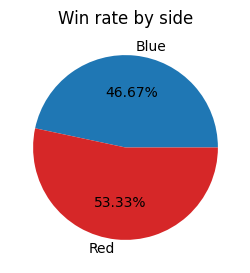

In [4]:
match_infos[["Side", "Win"]].groupby("Side").mean().plot.pie(
    y = "Win",
    autopct = "%.2f%%",
    figsize = (3, 3),
    title = "Win rate by side",
    legend = False,
    colors = ["tab:blue", "tab:red"],
    ylabel = ""
)
plt.show()

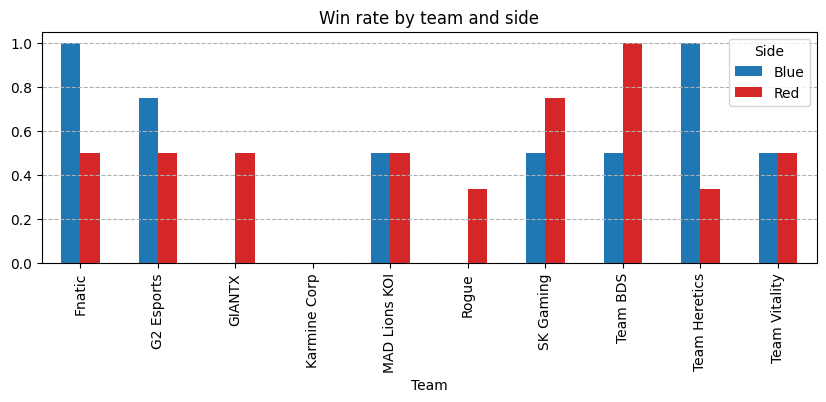

In [5]:
match_infos[["Side", "Team", "Win"]].groupby(["Team", "Side"]).mean().unstack().plot.bar(
    y = "Win",
    figsize = (10, 3),
    title = "Win rate by team and side",
    color = ["tab:blue", "tab:red"],
    ylabel = ""
)
plt.grid(axis = "y", linestyle = "--")
plt.show()

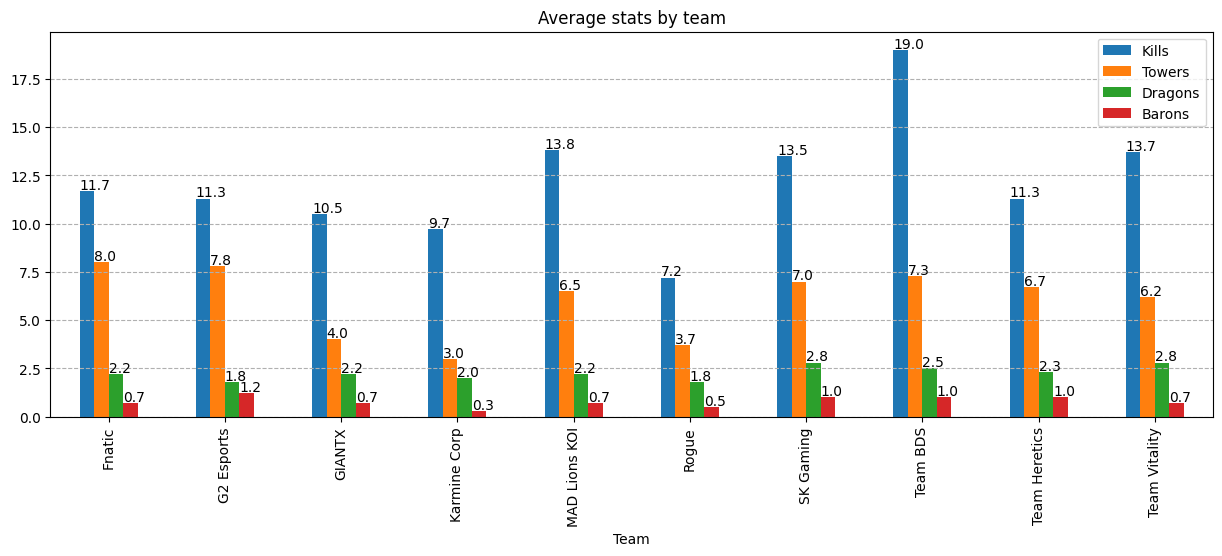

In [6]:
bar = match_infos[["Team", "Kills", "Towers", "Dragons", "Barons"]].groupby("Team").mean().round(1).plot.bar(
    figsize = (15, 5),
    title = "Average stats by team",
    ylabel = ""
)

for p in bar.patches:
    bar.annotate(str(float(p.get_height())), (p.get_x(), p.get_height()+0.1))

plt.grid(axis = "y", linestyle = "--")
plt.show()

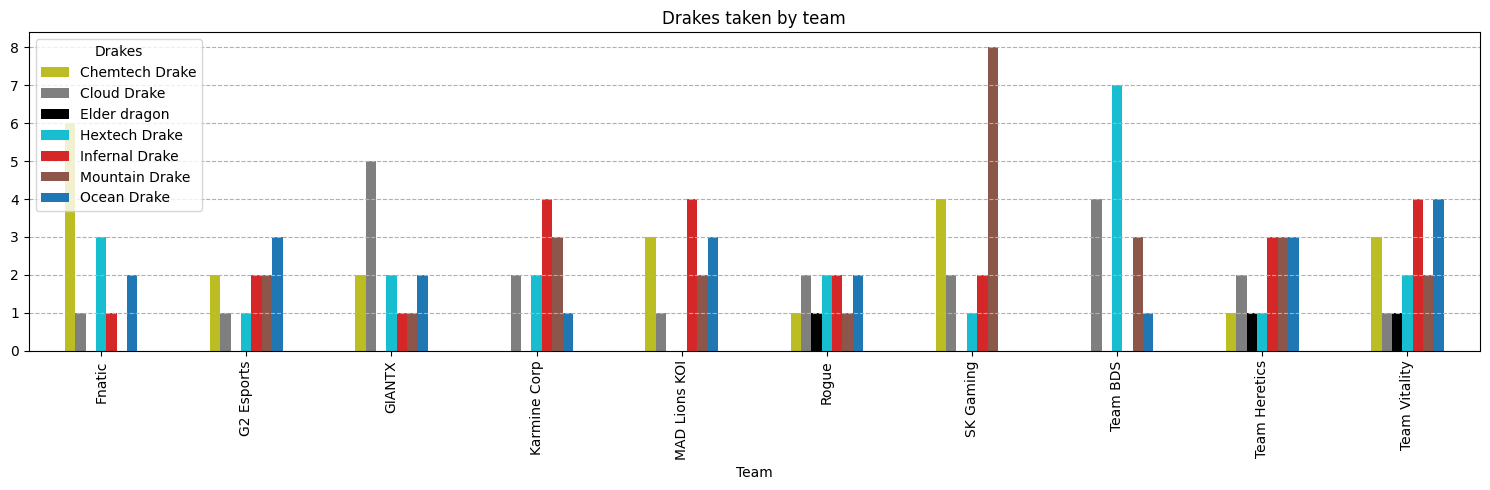

In [81]:
match_infos[["Team", "Drakes"]].explode("Drakes").groupby(["Team", "Drakes"]).size().unstack().plot.bar(
    figsize = (15, 5),
    title = "Drakes taken by team",
    ylabel = "",
    color=["tab:olive", "tab:grey", "black", "tab:cyan", "tab:red", "tab:brown", "tab:blue"]
)
plt.grid(axis = "y", linestyle = "--")
plt.tight_layout()
plt.show()

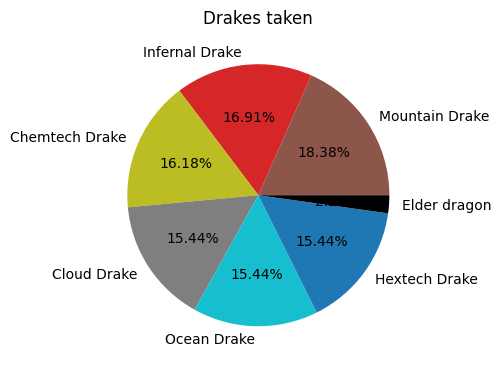

In [93]:
match_infos["Drakes"].explode().value_counts().plot.pie(
    autopct = "%.2f%%",
    figsize = (5, 5),
    title = "Drakes taken",
    ylabel = "",
    colors=["tab:brown", "tab:red", "tab:olive", "tab:grey", "tab:cyan", "tab:blue", "black"]
)
plt.tight_layout()
plt.show()

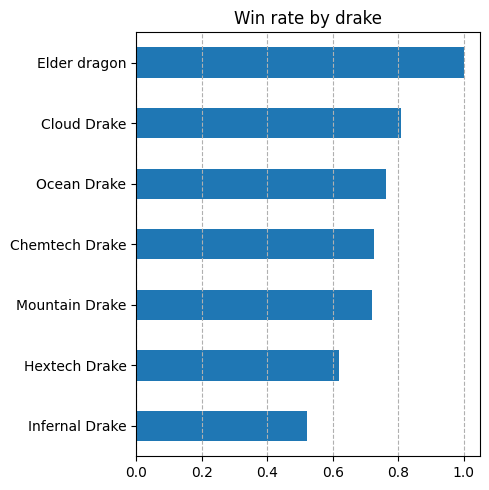

In [100]:
match_infos[["Drakes", "Win"]].explode("Drakes").groupby("Drakes").mean().sort_values("Win").plot.barh(
    figsize = (5, 5),
    title = "Win rate by drake",
    ylabel = "",
    color = "tab:blue",
    legend = False
)
plt.grid(axis = "x", linestyle = "--")
plt.tight_layout()
plt.show()

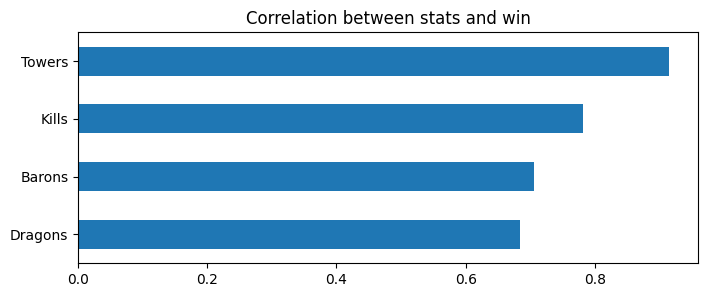

In [7]:
match_infos[["Win", "Kills", "Towers", "Dragons", "Barons"]].corr()["Win"].iloc[1:].sort_values().plot.barh(
    figsize = (8, 3),
    title = "Correlation between stats and win",
    ylabel = ""
)
plt.show()

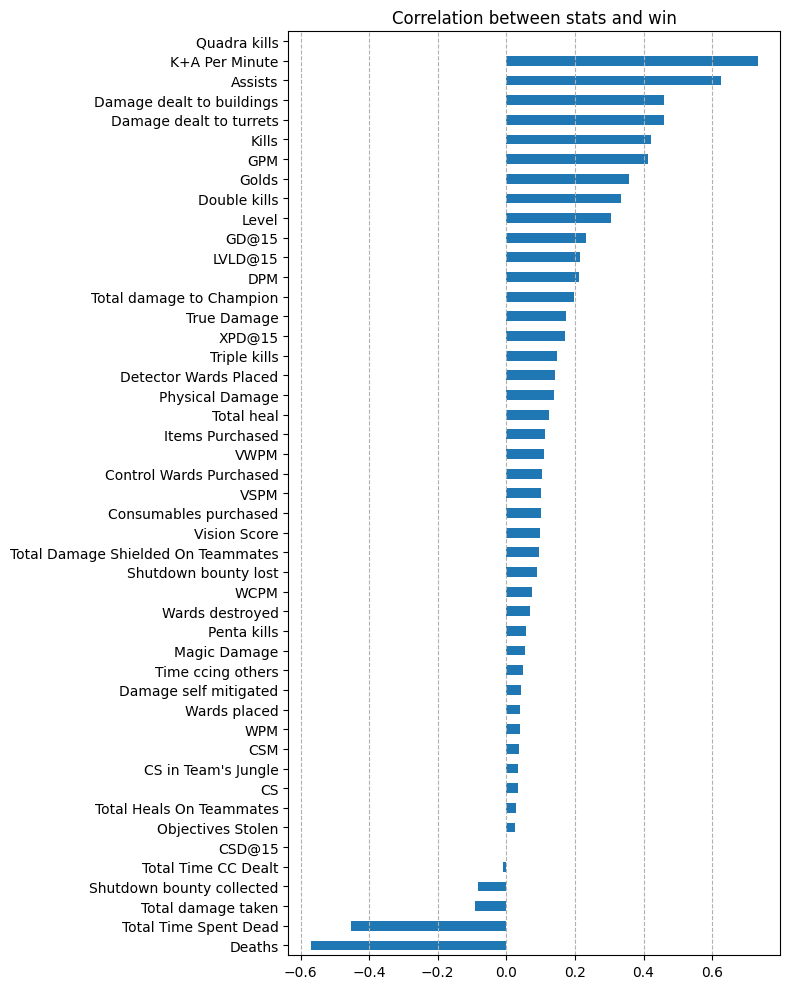

In [70]:
game_stats.drop(columns=["Player", "Role", "Team", "Champion", "Game ID"]).corr()["Win"].iloc[:-1].sort_values().plot.barh(
    figsize = (8, 10),
    title = "Correlation between stats and win",
    ylabel = ""
)
plt.tight_layout()
plt.grid(axis = "x", linestyle = "--")
plt.show()

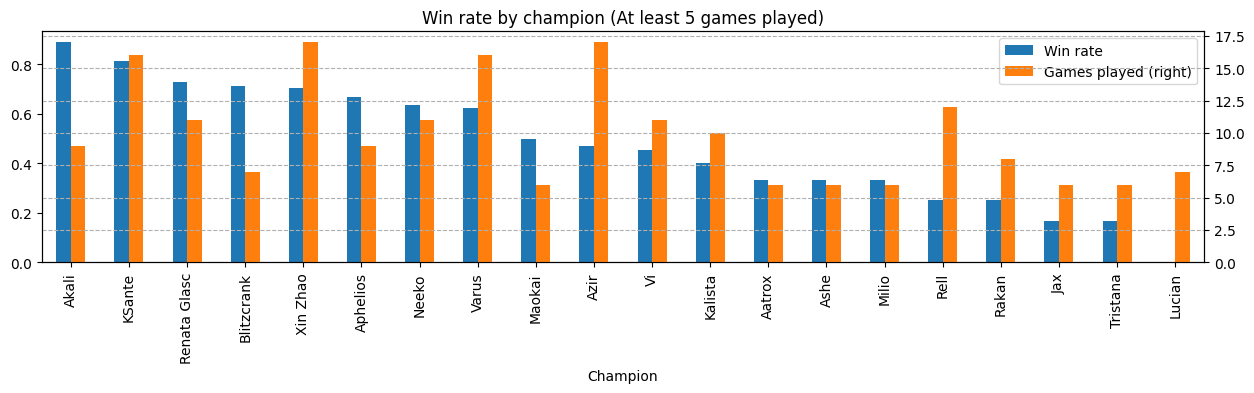

In [8]:
champ_wr = game_stats[["Win", "Champion"]].groupby("Champion").agg(["mean", "count"])["Win"].sort_values(["mean", "count"], ascending=False)
champ_wr.rename(columns={"mean": "Win rate", "count": "Games played"}, inplace=True)
champ_wr[champ_wr["Games played"] > 5].plot.bar(
    figsize = (15, 3),
    title = "Win rate by champion (At least 5 games played)",
    secondary_y = "Games played",
)
plt.grid(axis = "y", linestyle = "--")
plt.show()

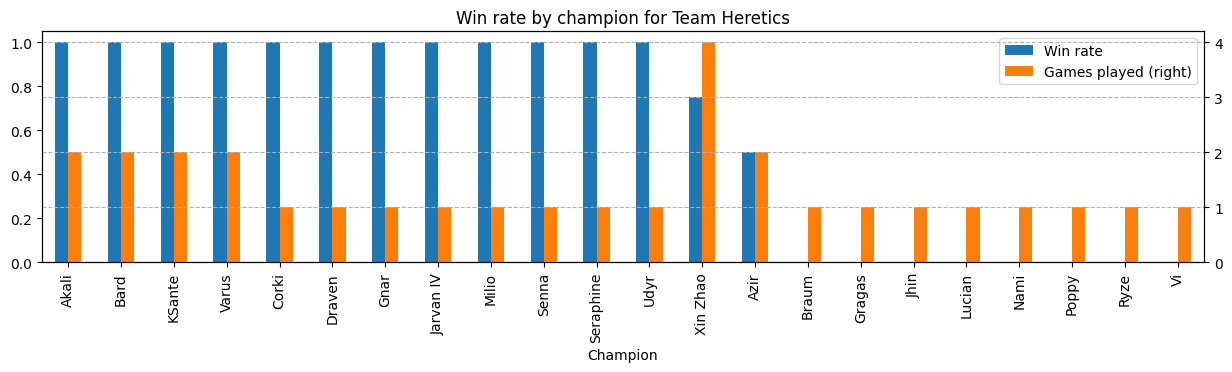

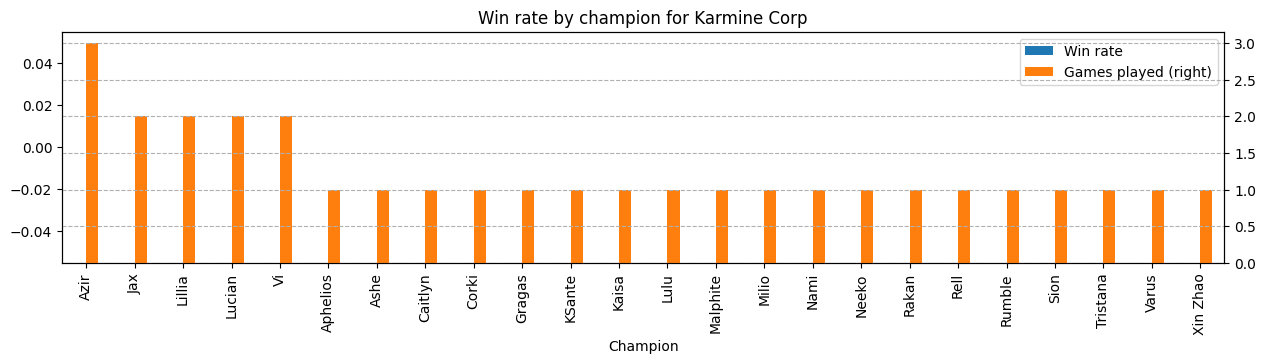

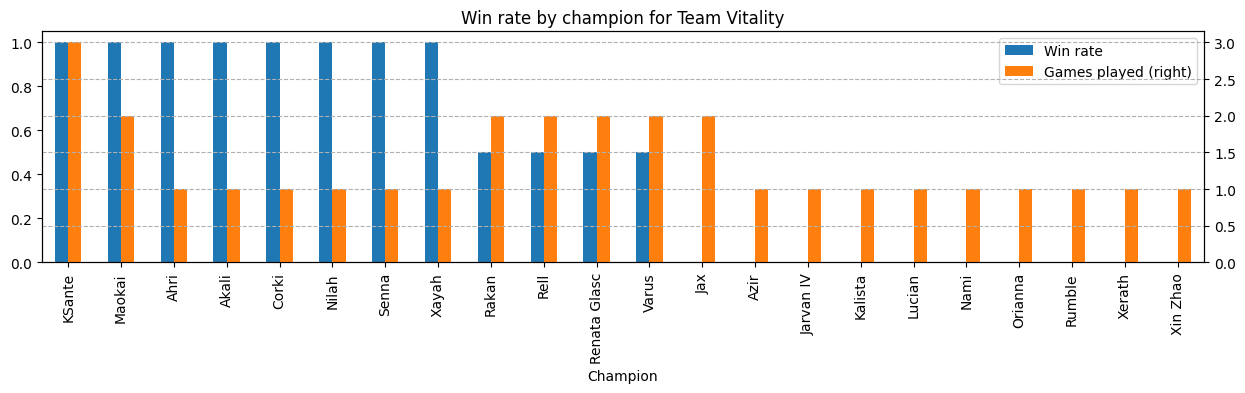

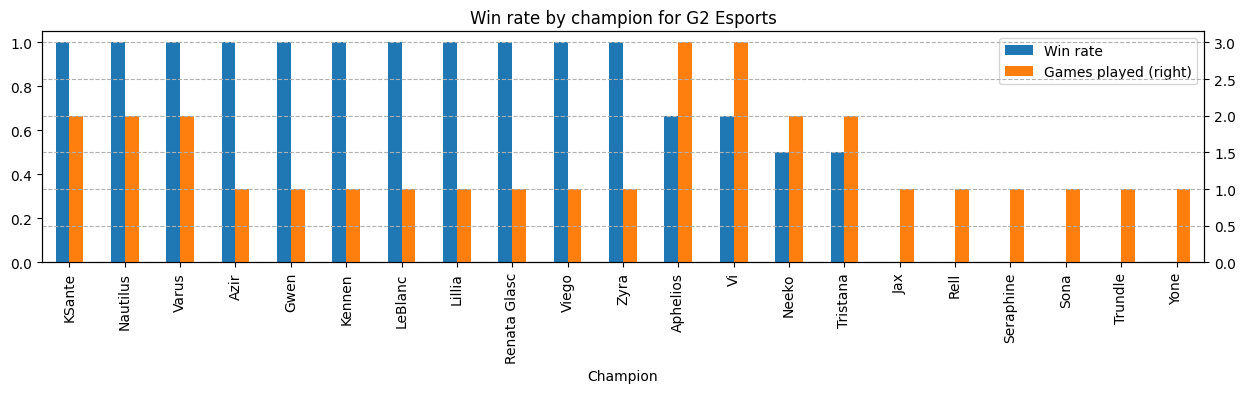

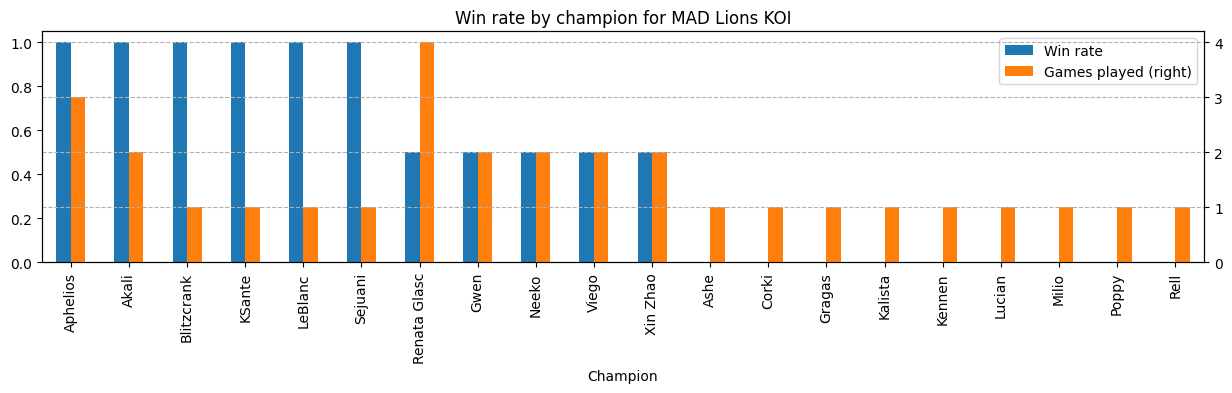

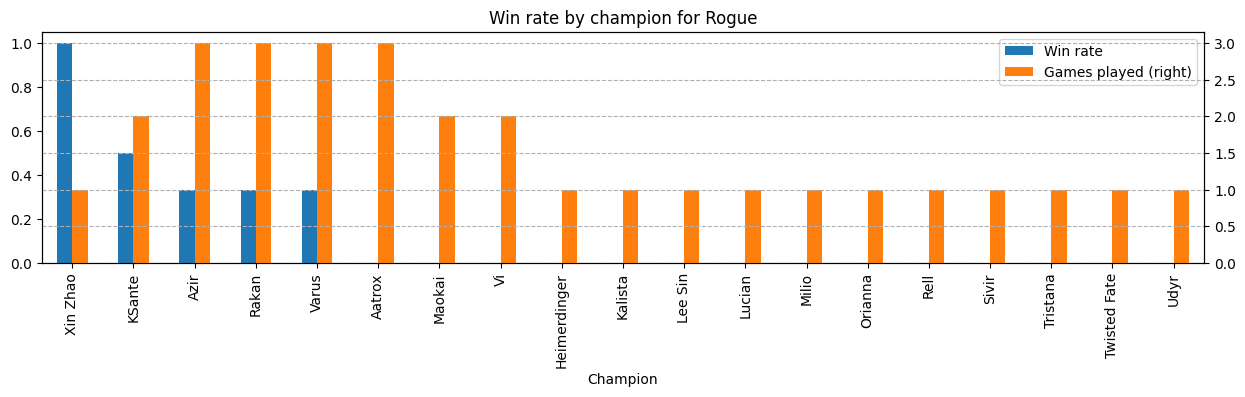

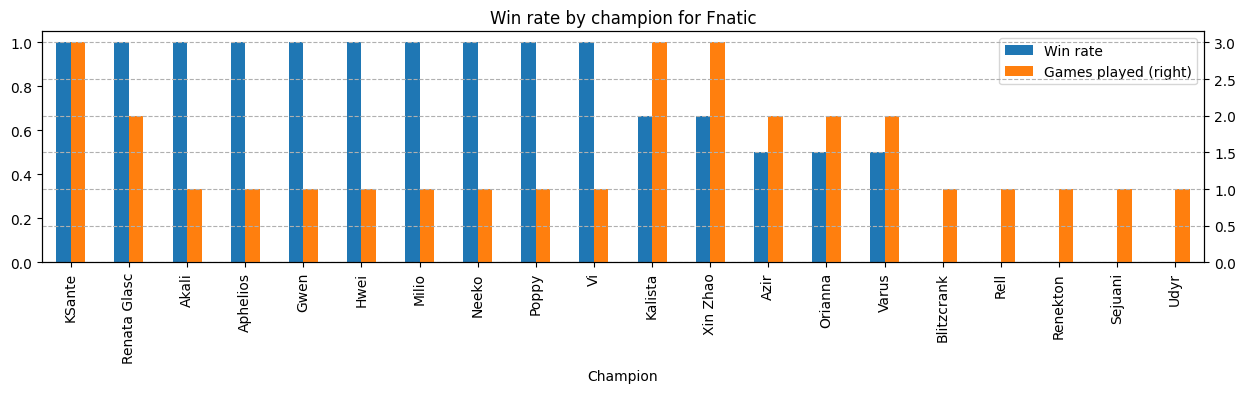

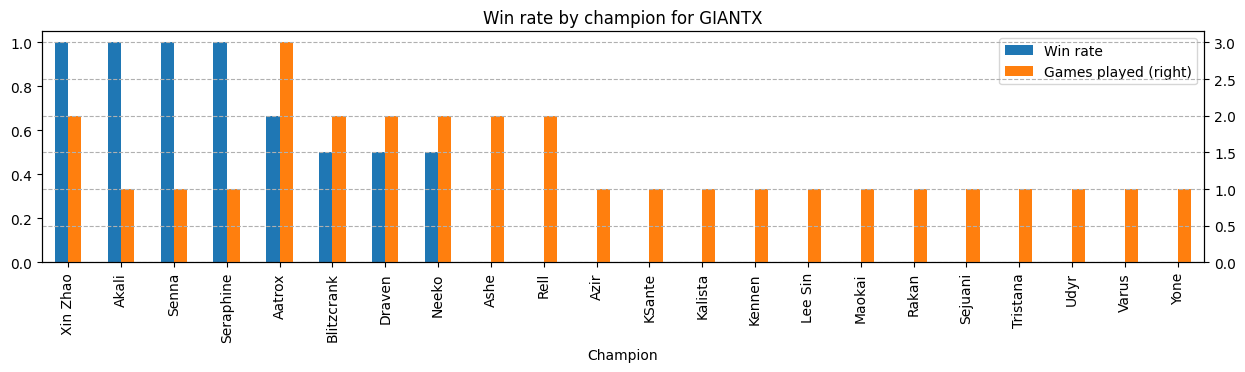

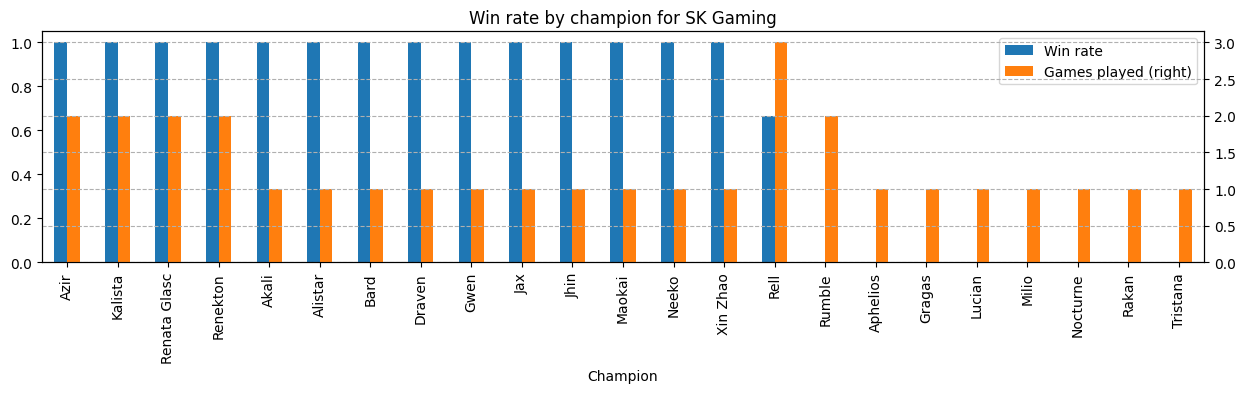

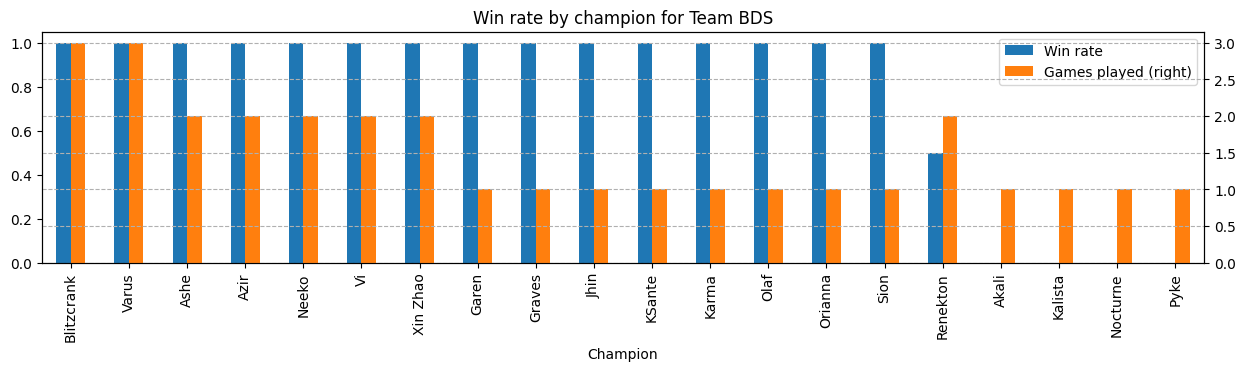

In [9]:
for team in match_infos["Team"].unique():
    team_champ_wr = game_stats[game_stats["Team"] == team][["Win", "Champion"]].groupby("Champion").agg(["mean", "count"])["Win"].sort_values(["mean", "count"], ascending=False)
    team_champ_wr.rename(columns={"mean": "Win rate", "count": "Games played"}, inplace=True)
    team_champ_wr.plot.bar(
        figsize = (15, 3),
        title = f"Win rate by champion for {team}",
        secondary_y = "Games played",
    )
    plt.grid(axis = "y", linestyle = "--")
    plt.show()

Je me suis arrêté ici

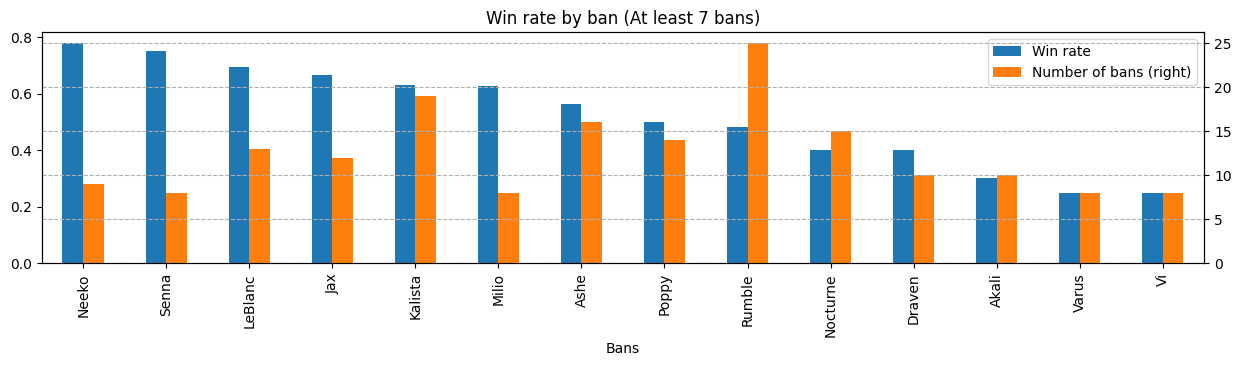

In [30]:
ban_wr = match_infos[["Bans", "Win"]].explode("Bans").groupby("Bans").agg(["mean", "count"])["Win"].sort_values(["mean", "count"], ascending=False)
ban_wr.rename(columns={"mean": "Win rate", "count": "Number of bans"}, inplace=True)
ban_wr[ban_wr["Number of bans"] > 7].plot.bar(
    figsize = (15, 3),
    title = "Win rate by ban (At least 7 bans)",
    secondary_y = "Number of bans",
)
plt.grid(axis = "y", linestyle = "--")
plt.show()

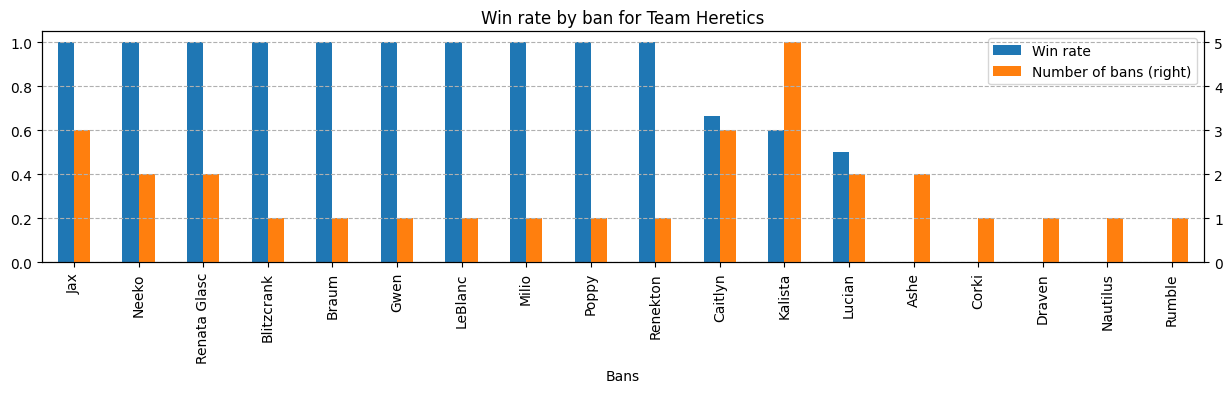

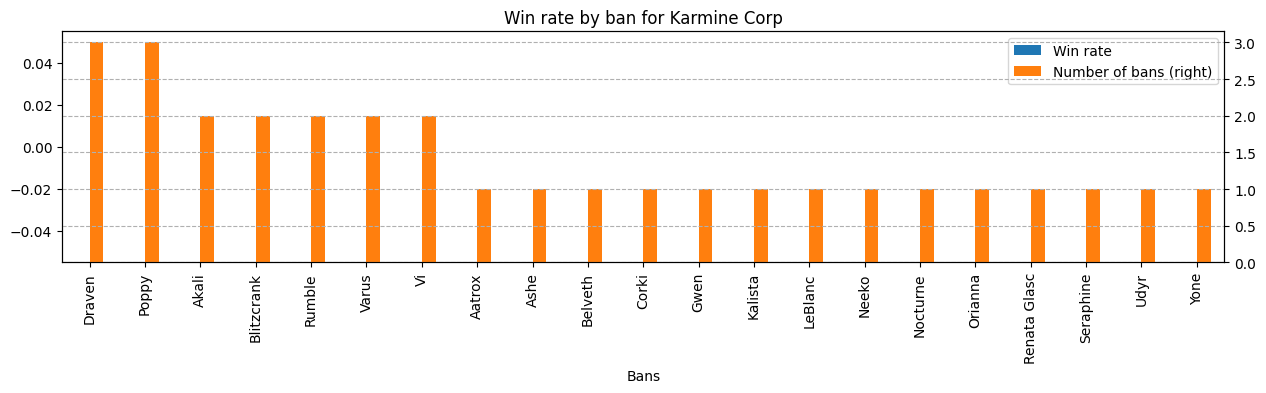

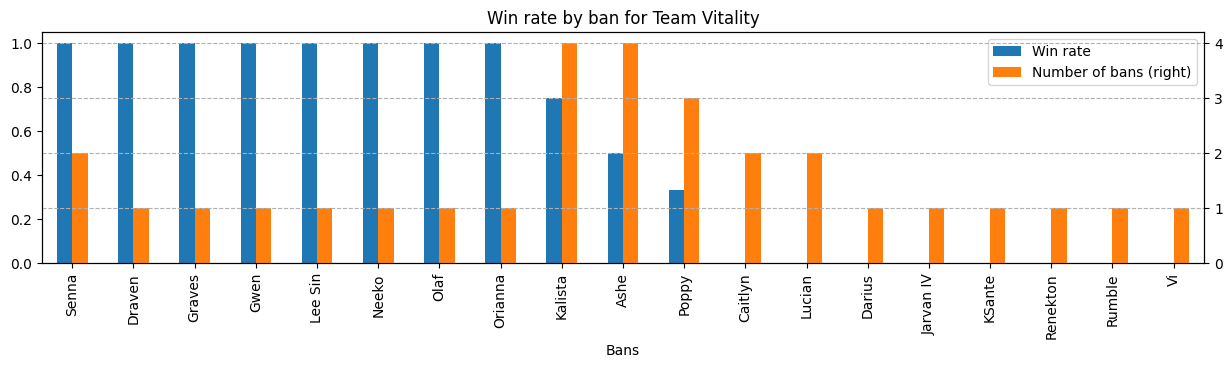

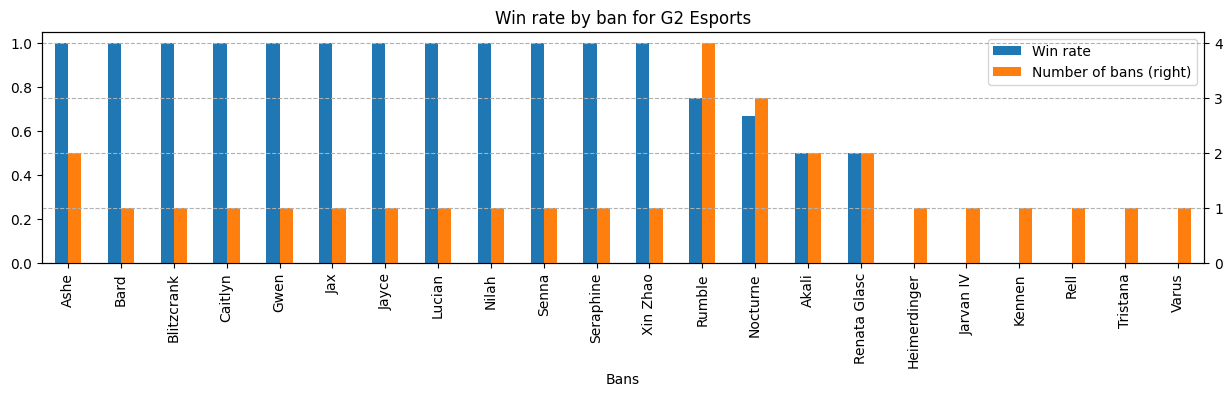

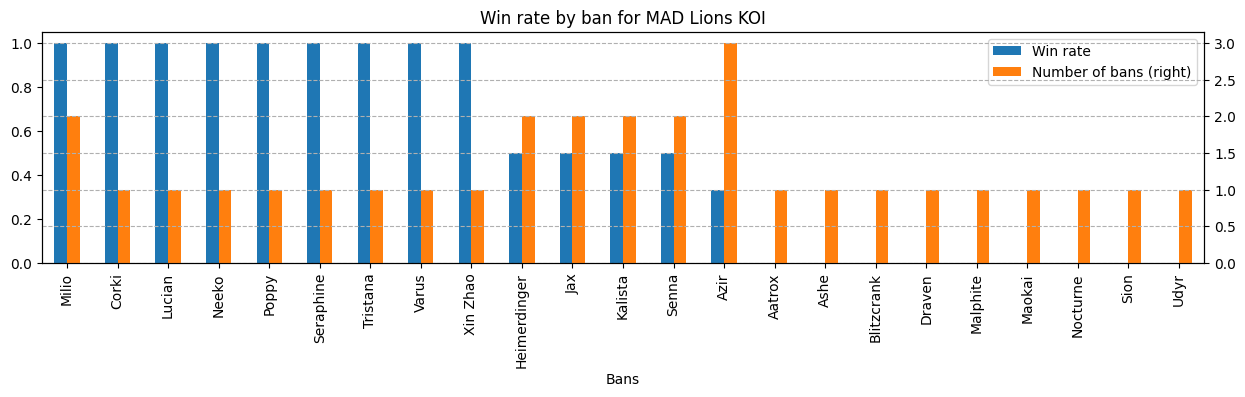

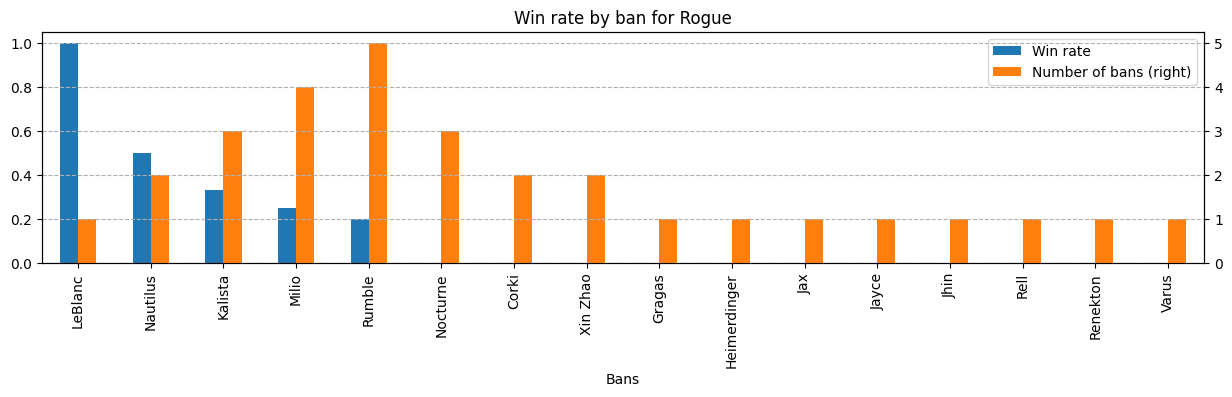

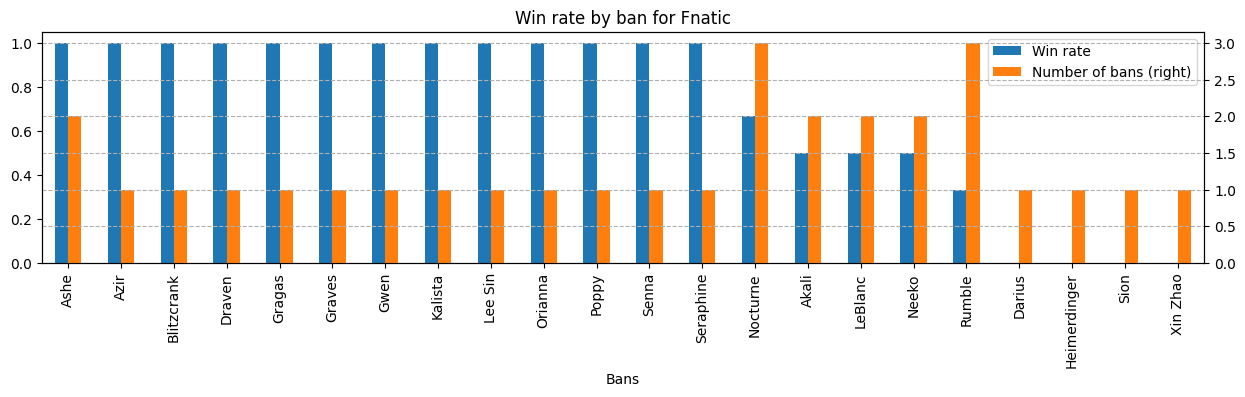

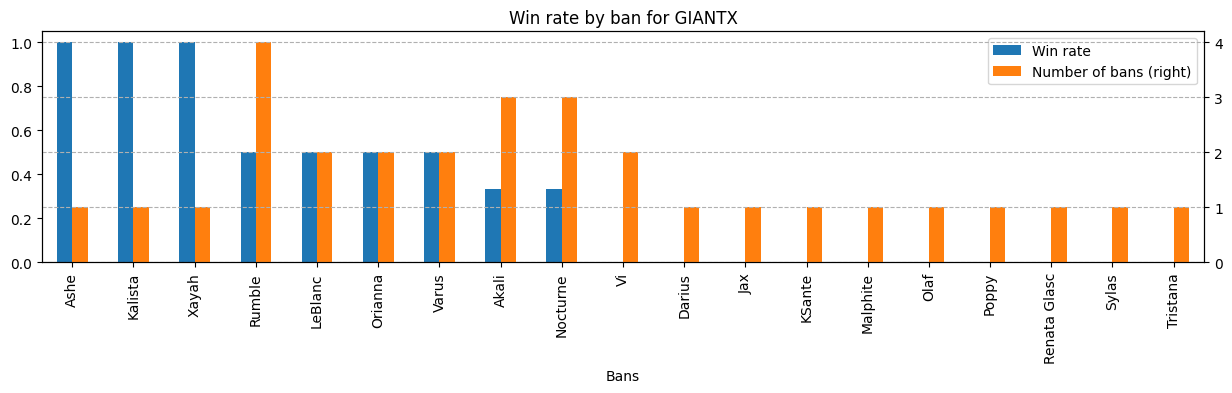

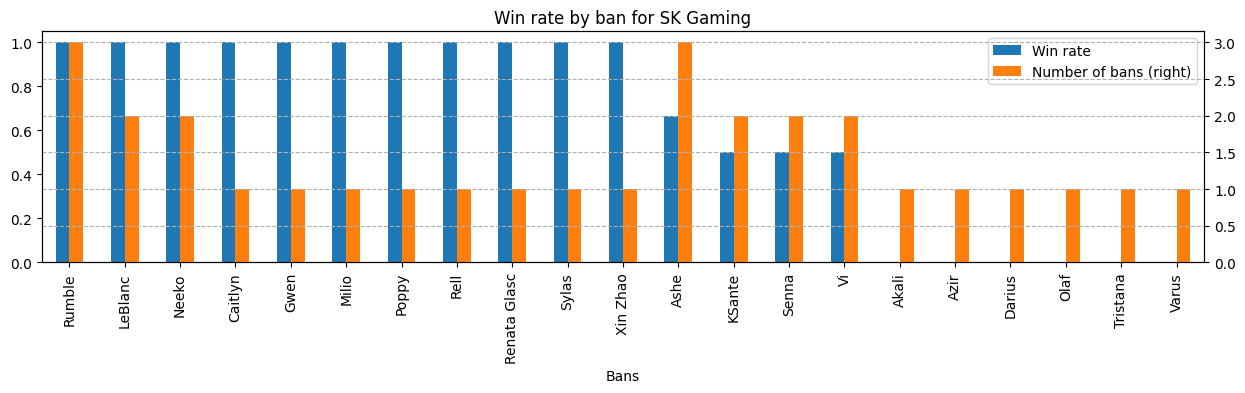

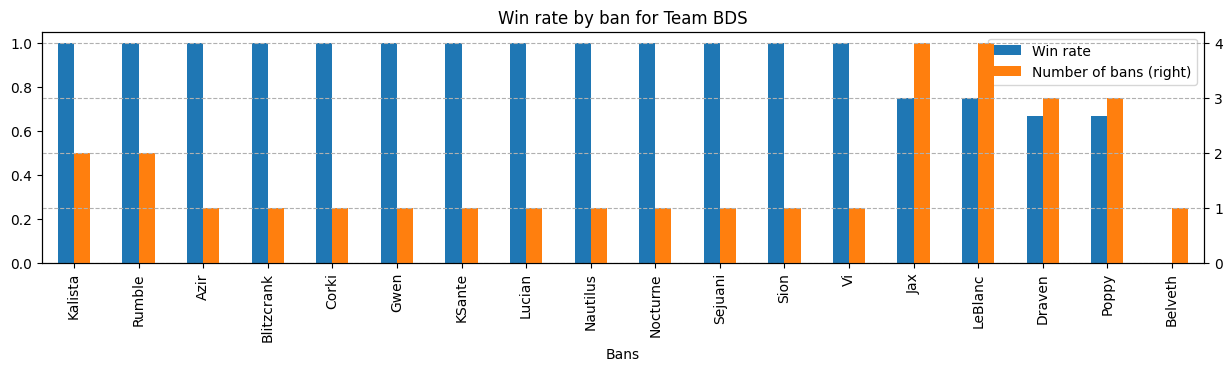

In [33]:
for team in match_infos["Team"].unique():
    team_ban_wr = match_infos[match_infos["Team"] == team][["Bans", "Win"]].explode("Bans").groupby("Bans").agg(["mean", "count"])["Win"].sort_values(["mean", "count"], ascending=False)
    team_ban_wr.rename(columns={"mean": "Win rate", "count": "Number of bans"}, inplace=True)
    team_ban_wr.plot.bar(
        figsize = (15, 3),
        title = f"Win rate by ban for {team}",
        secondary_y = "Number of bans",
    )
    plt.grid(axis = "y", linestyle = "--")
    plt.show()

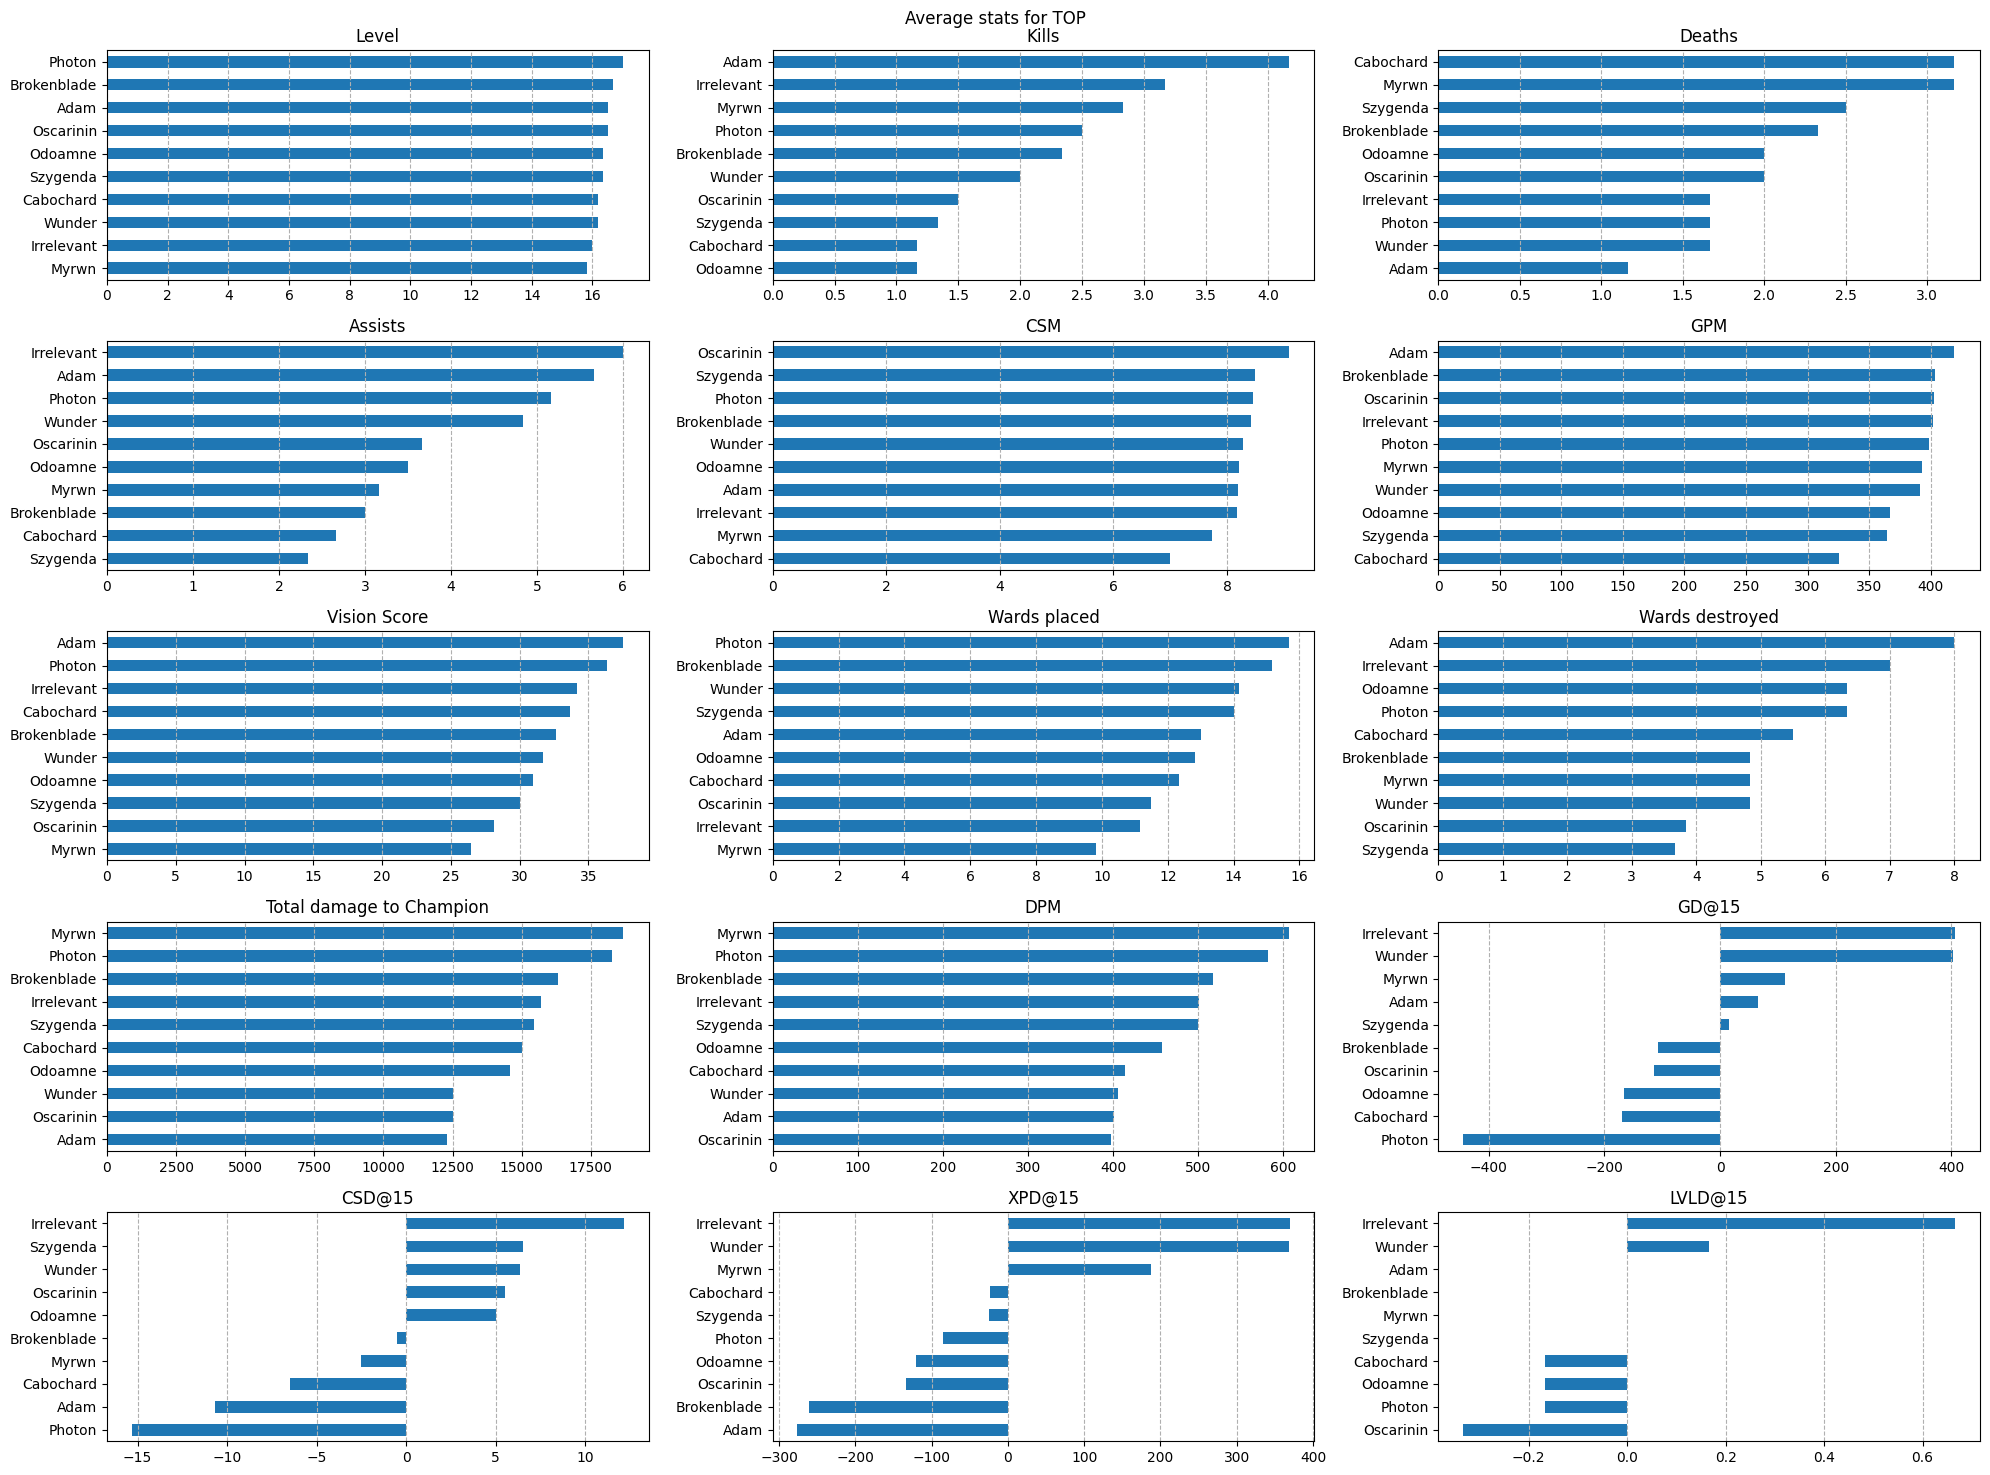

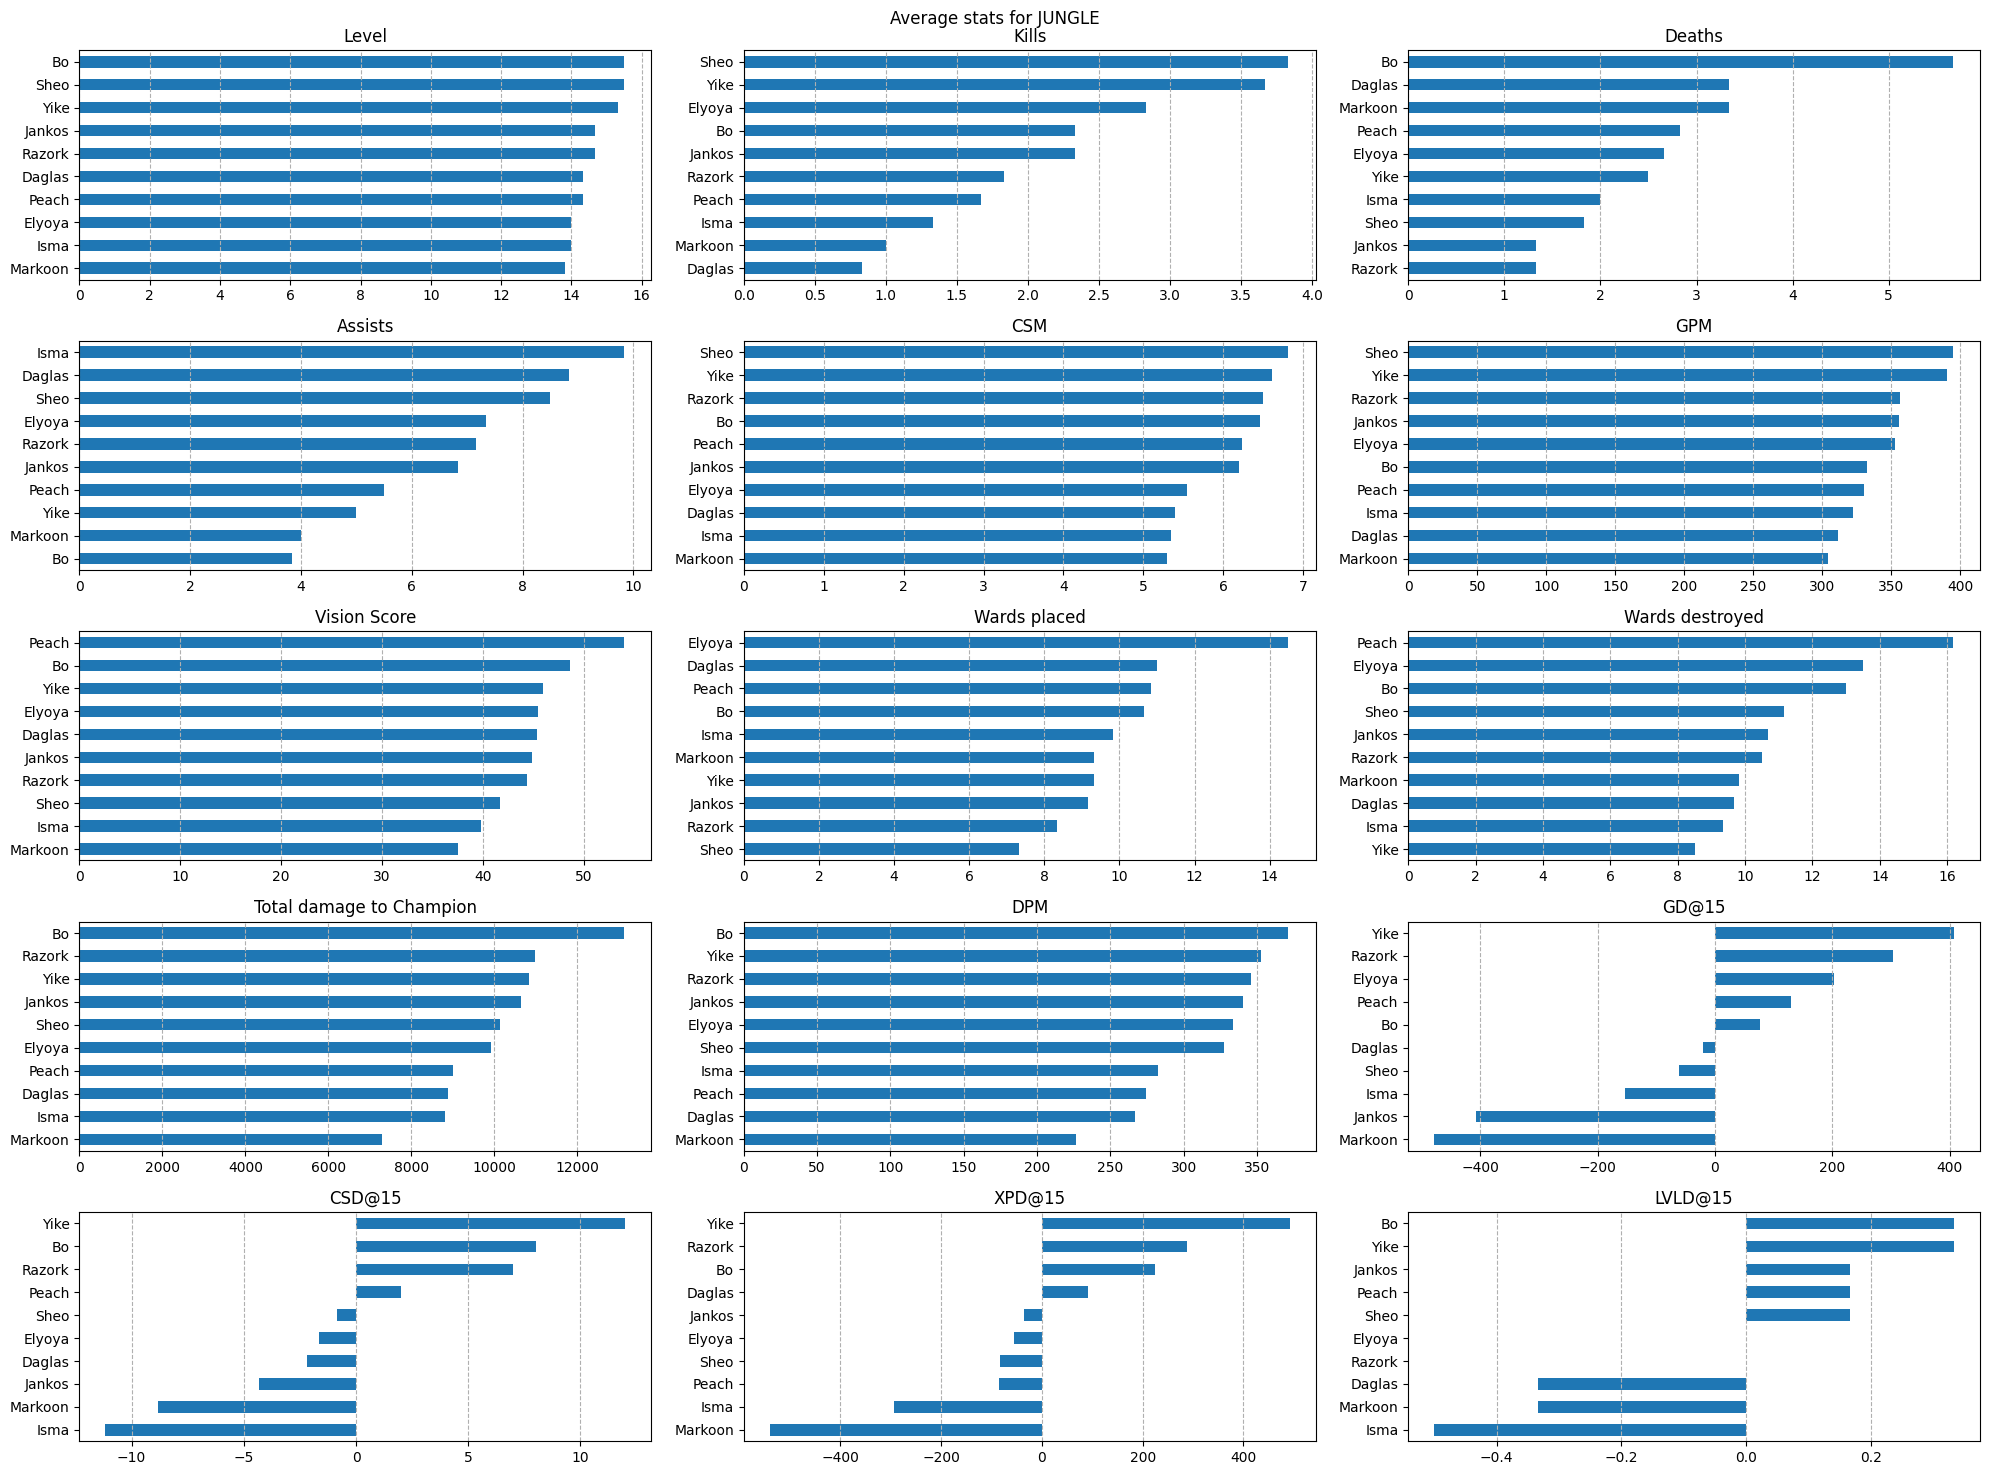

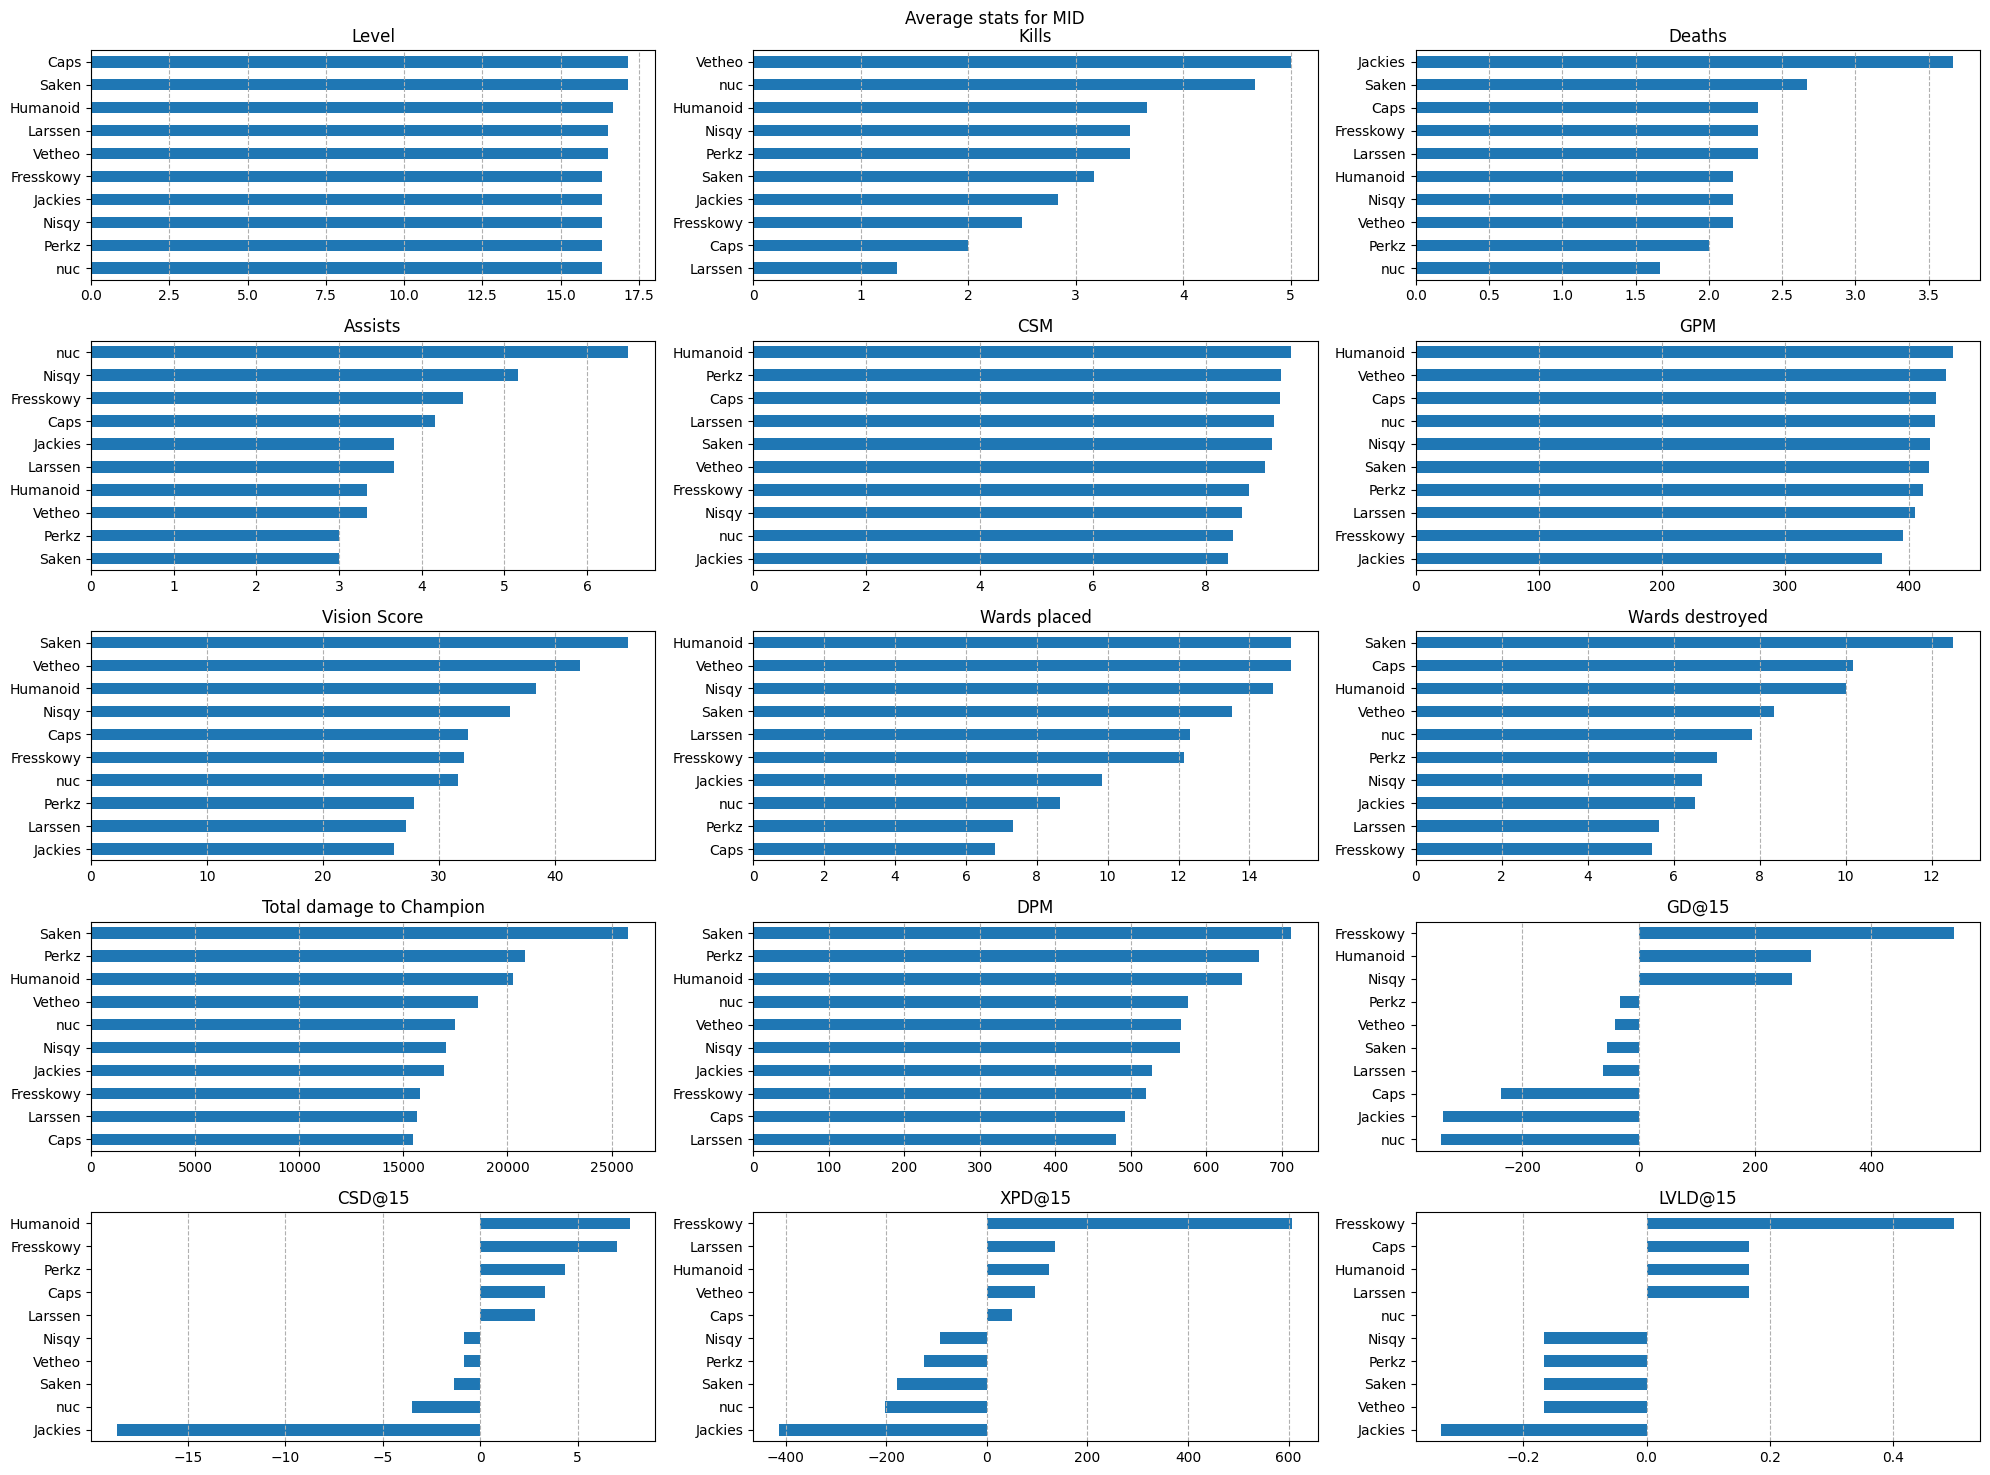

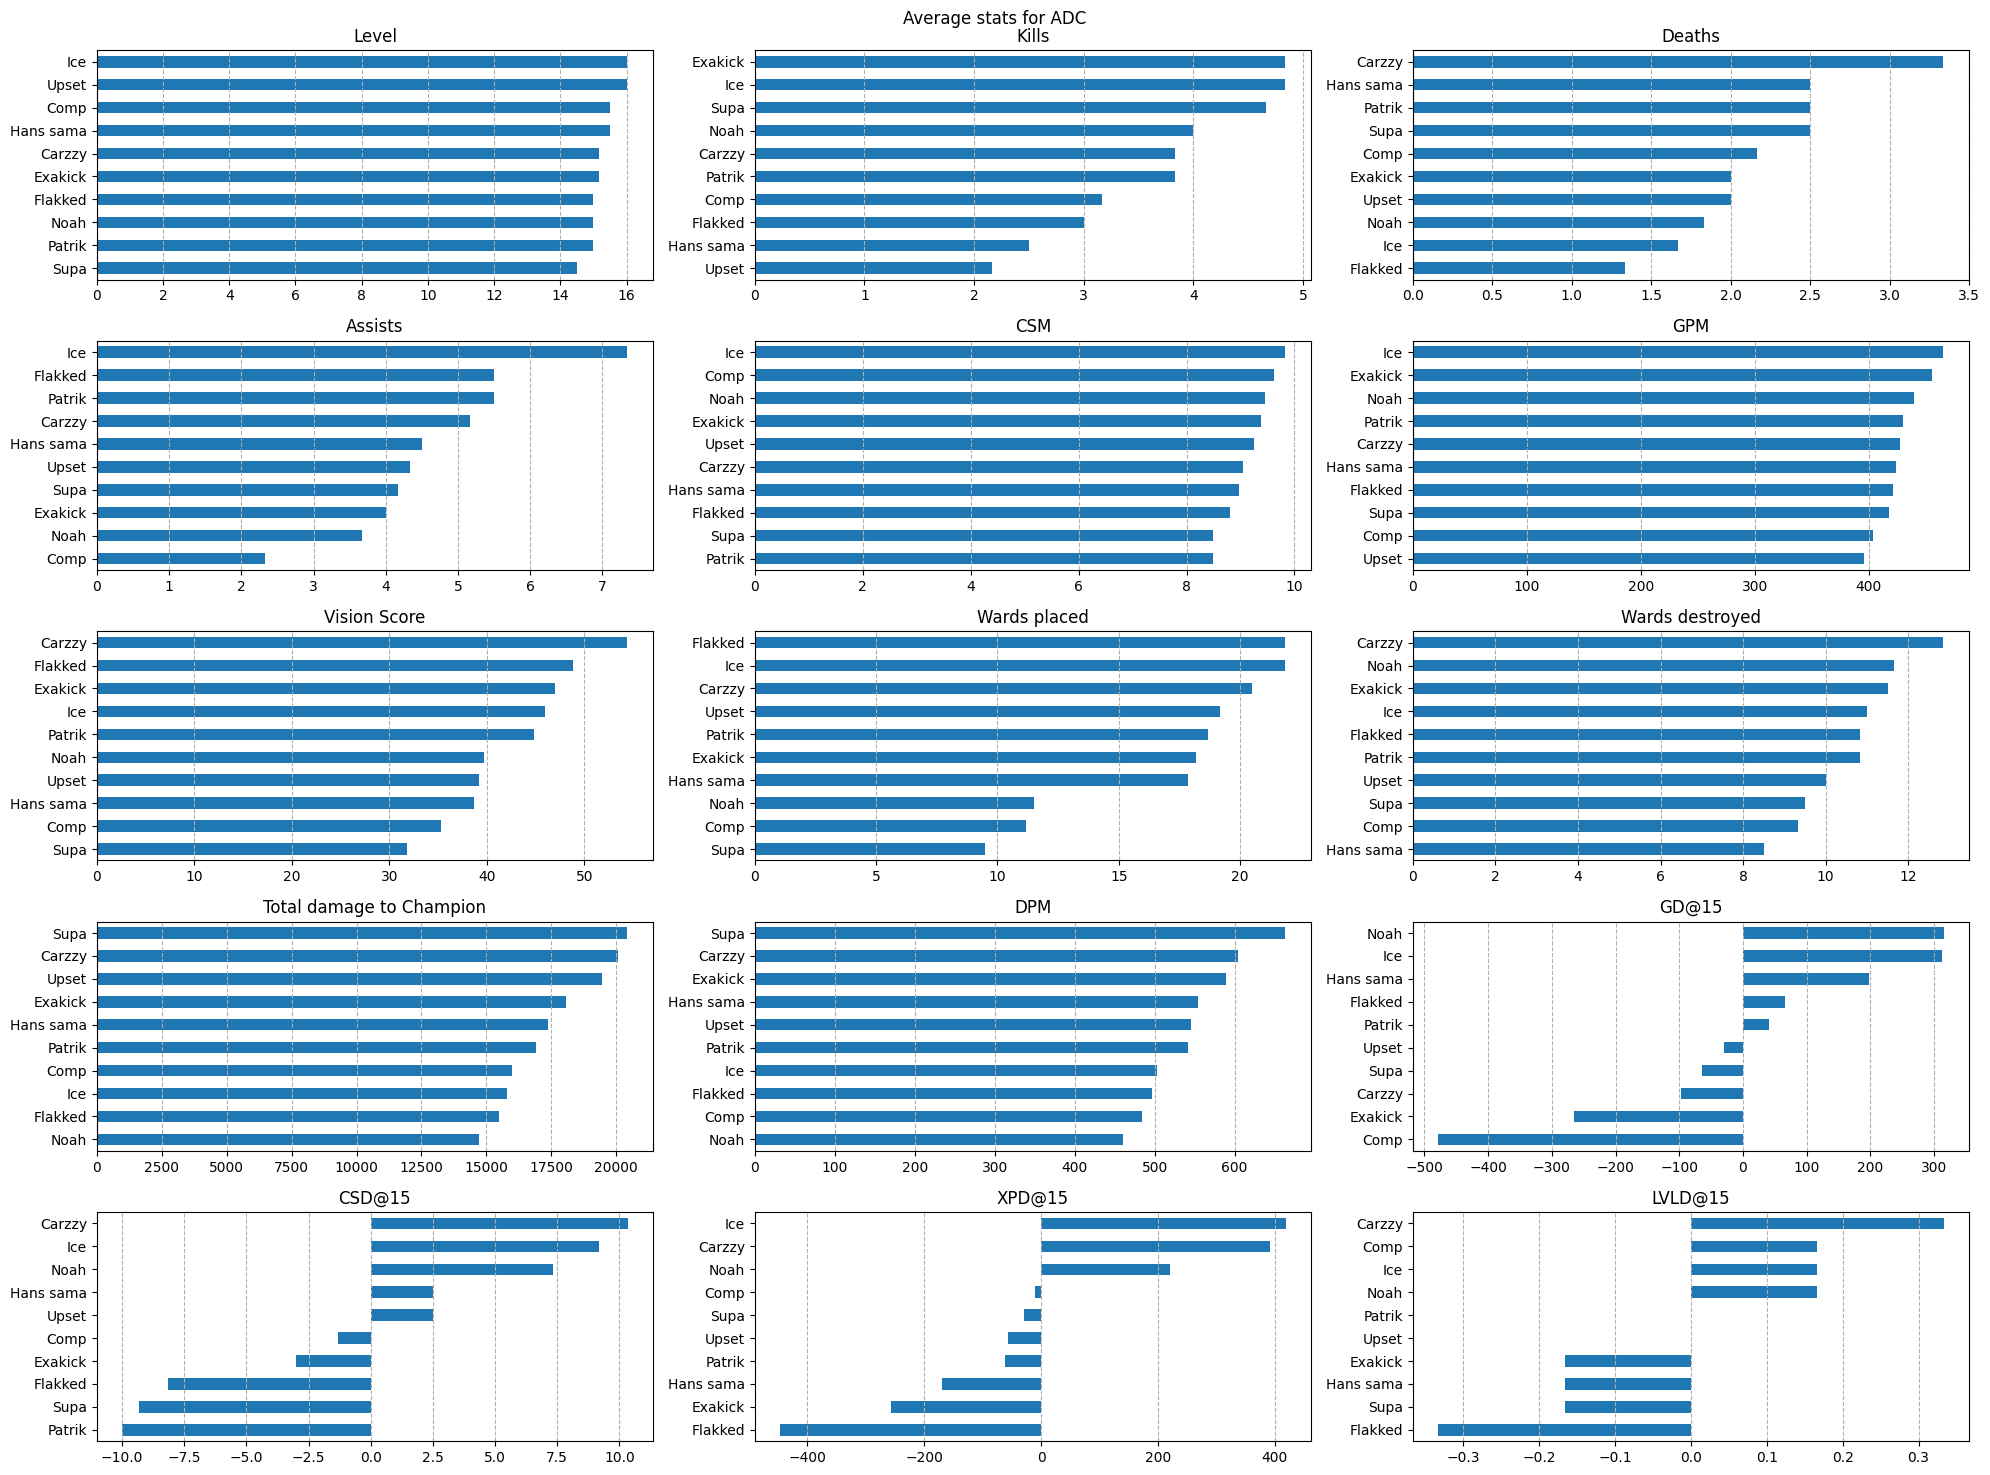

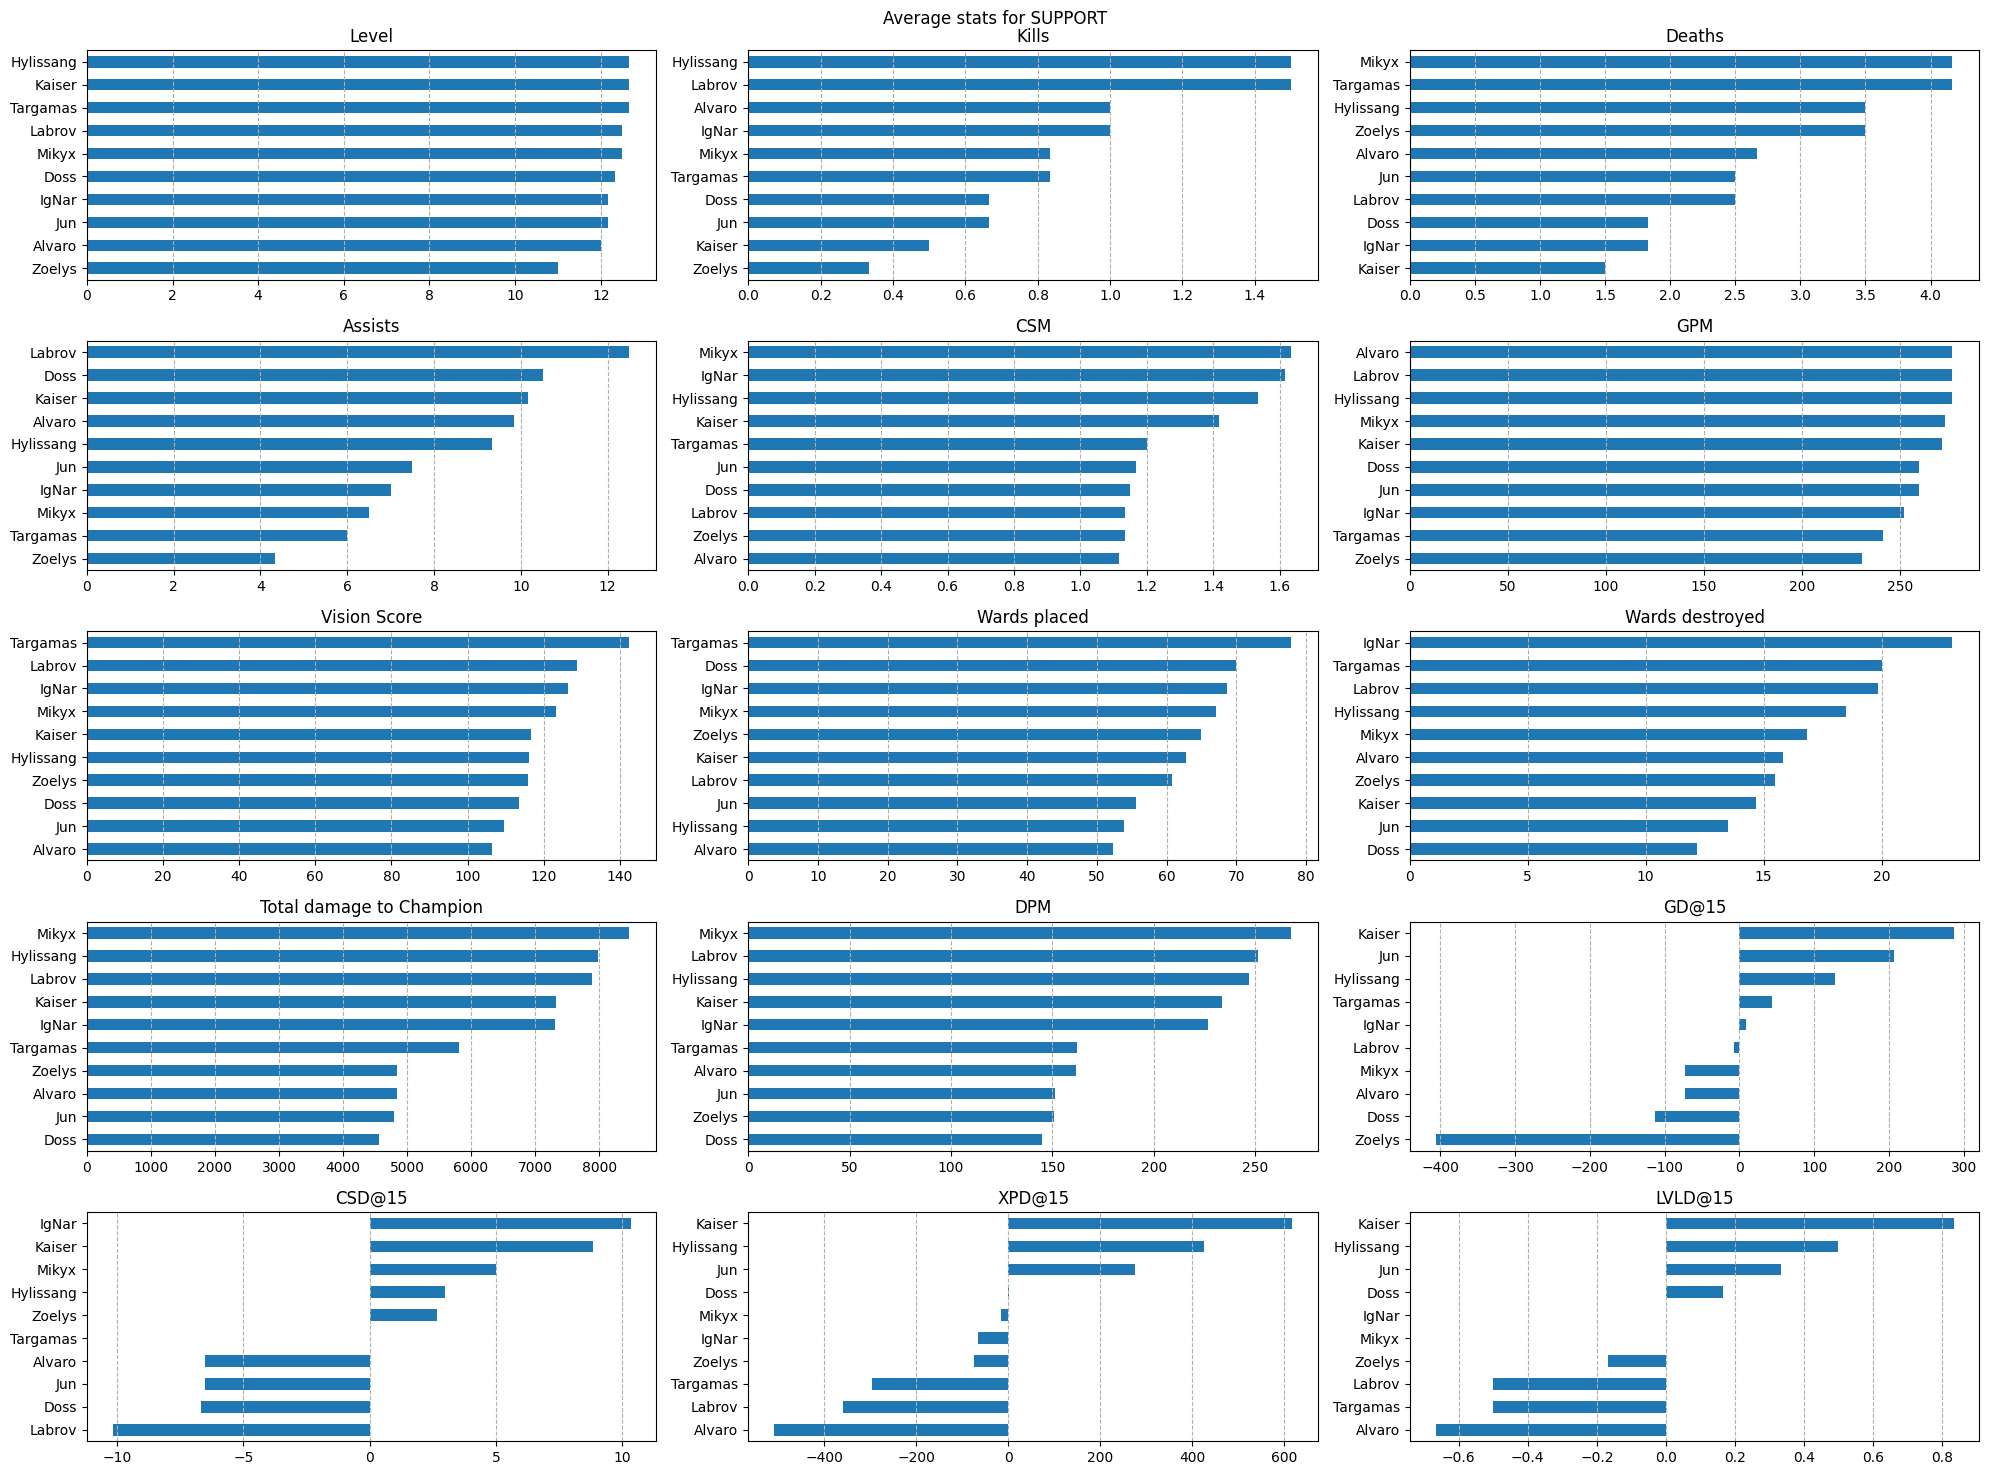

In [63]:
stats_to_plots = ["Level", "Kills", "Deaths", "Assists", "CSM", "GPM", "Vision Score", "Wards placed", "Wards destroyed", "Total damage to Champion", "DPM", "GD@15", "CSD@15", "XPD@15", "LVLD@15"]

for role in game_stats["Role"].unique():
    fig, axis = plt.subplots(5, 3, figsize = (20, 15))
    fig.suptitle(f"Average stats for {role}")
    for ax, stat in zip(axis.flatten(), stats_to_plots):
        game_stats[game_stats["Role"] == role].groupby("Player")[stats_to_plots].mean().sort_values(stat, ascending=False)[stat][::-1].plot.barh(
            ax = ax, 
            title = stat,
            ylabel = "",
        )
        ax.grid(axis = "x", linestyle = "--")
    plt.tight_layout()
    plt.show()